In [2]:
import matplotlib.pyplot as plt; plt.style.use('/home/hugo/Thèse/styles.mplstyle')
import matplotlib as mpl
import pandas as pd
import librosa
import numpy as np
import sklearn.neighbors, sklearn.preprocessing, sklearn.metrics, sklearn.pipeline, sklearn.svm, sklearn.feature_selection, sklearn.neural_network, sklearn.model_selection
import tqdm
import itertools
import scipy.io
import glob

import sys; sys.path.insert(0, '..')
from src.features import *

# FRFs

In [9]:
frfs = []
for violin in ['Klimke', 'Levaggi', 'Stoppani']:
    files = glob.glob(f'../data/raw/CNSM/Admittance/*{violin}*.mat')
    
    for file in files:
        mat     = scipy.io.loadmat(file)

        sr      = mat['freq'][0, 0]
        n_fft   = mat['npts'][0, 0]
        if n_fft != 32768: continue
        f       = np.linspace(0, sr//2, n_fft//2+1)
        X       = mat['yspec'][:, 1]
        Y       = mat['yspec'][:, 0]
        H       = 20 * np.log10(np.abs(Y/X))
        # H_c     = 20 * np.log10(np.abs(Y/X) * Ss_mean)
        

        # S = np.expand_dims(H, axis=0).T
        # mfcc = librosa.feature.mfcc(S=S, sr=sr, n_mfcc=100, n_fft=n_fft, hop_length=n_fft).T
        # mfcc = np.median(mfcc, axis=0)
        # H = mfcc
        # H[0]=0
        # f = np.arange(100)

        frf = {
            'file': file,
            'violin': violin,
            'sr': sr,
            'n_fft': n_fft,
            'f': f,
            'X': X,
            'Y': Y,
            'H': H,
            # 'H_c': H_c,
        }
        frfs.append(frf)

frfs = pd.DataFrame(frfs)

(200, 5000)

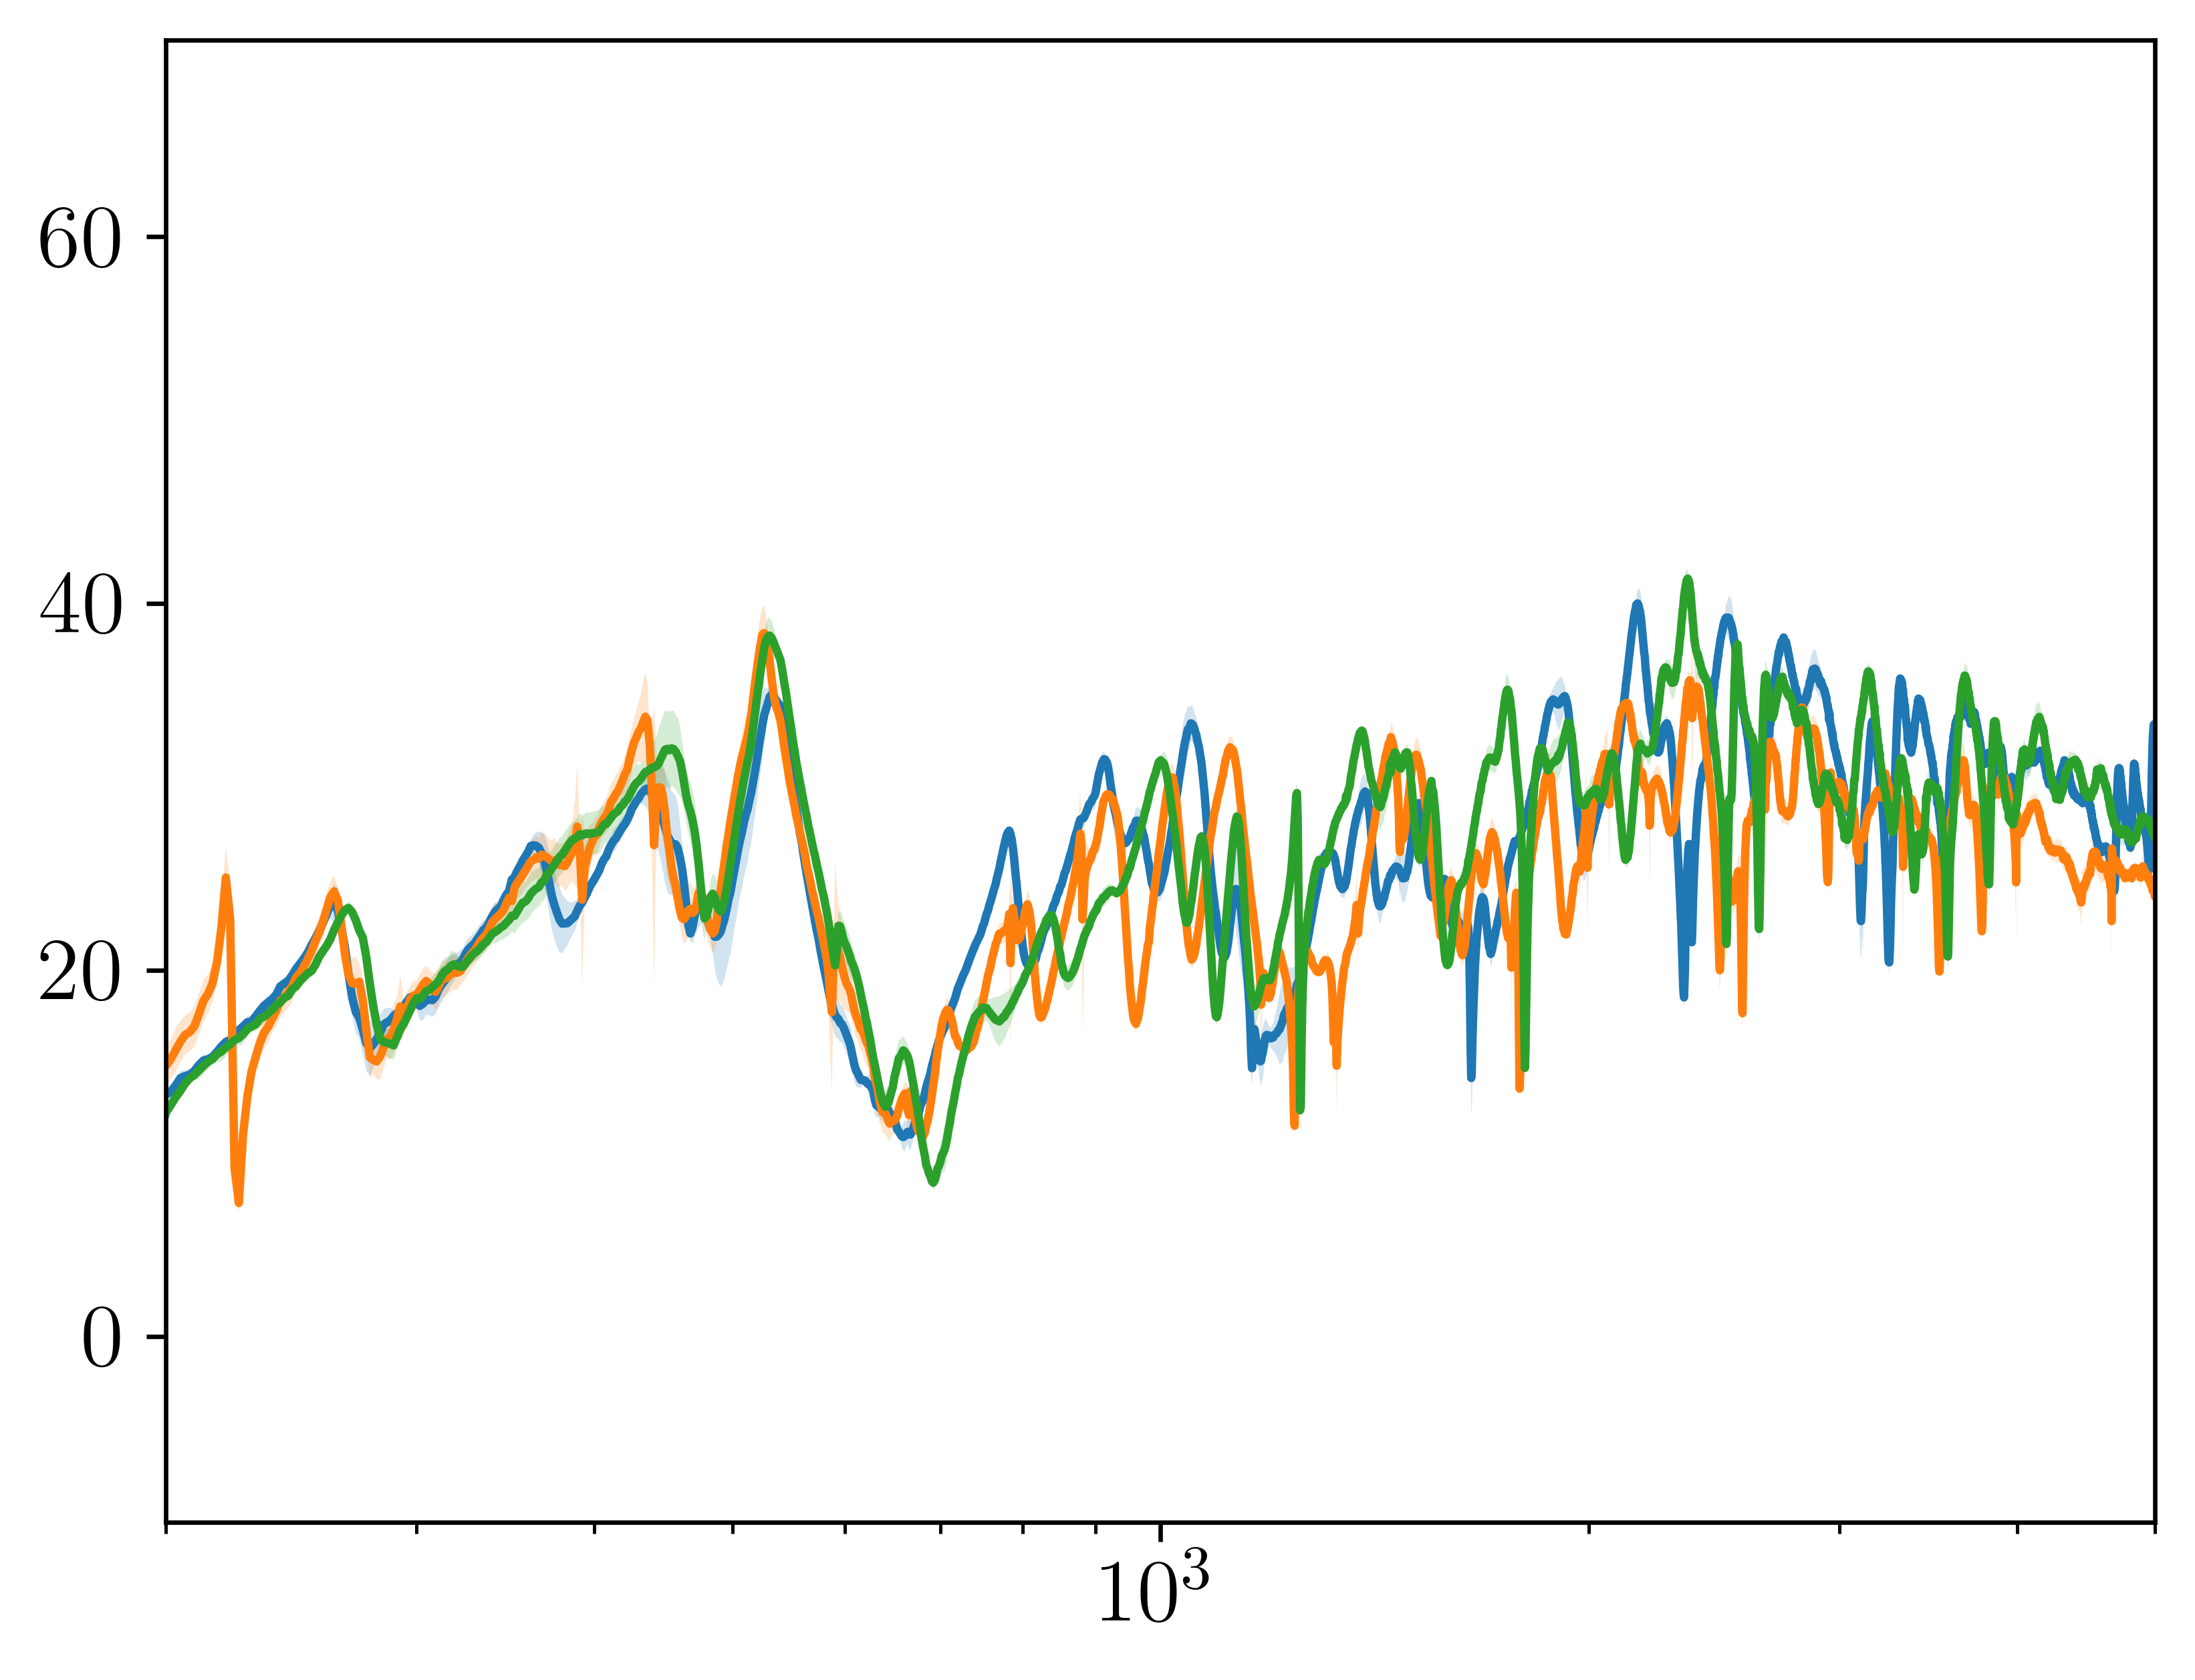

In [10]:
# std fix for numpy arrays dataframes
def std(group):
    group = np.vstack(group)
    std = np.std(group, axis=0)
    return std

fig, ax = plt.subplots()
stats = frfs.groupby('violin')['H'].agg(['mean', std])
stats['f'] = frfs.groupby('violin')['f'].first()
for i, row in stats.iterrows():
    ax.plot(row['f'], row['mean'])
    ax.fill_between(
        row['f'],
        row['mean'] + row['std'],
        row['mean'] - row['std'],
        alpha=.2
    )
ax.set_xscale('log')
ax.set_xlim([200, 5000])
# ax.set_ylim([0, 100])

# LTAS

In [11]:
sr      = 48000
n_fft   = 32768

df = pd.read_pickle('../data/processed/dataset_cnsm.pkl')
# df = df[(df.extract == 'tchai') & (df.violin == 'A')]

ltass = []
for violin in ['A', 'B', 'C']:
    for i, row in df[(df.violin == violin)].iloc[:100].iterrows():
        audio, sr = librosa.load(
            row.file, 
            offset=row.start, 
            duration=row.end - row.start, 
            sr=sr
        )
        f       = np.linspace(0, sr//2, n_fft//2+1)
        ltas    = LTAS(audio, n_fft, n_fft//2)
        ltas    = 20 * np.log(ltas)
        
        if n_fft != 32768: continue

        # S = np.expand_dims(ltas, axis=0).T
        # mfcc = librosa.feature.mfcc(S=S, sr=sr, n_mfcc=100, n_fft=n_fft, hop_length=n_fft).T
        # mfcc = np.median(mfcc, axis=0)
        # ltas = mfcc
        # ltas[0]=0
        # f = np.arange(100)

        ltas = {
            'file': row.file,
            'violin': violin,
            'sr': sr,
            'n_fft': n_fft,
            'f': f,
            'H': ltas,
        }
        ltass.append(ltas)

ltass = pd.DataFrame(ltass)

(200, 5000)

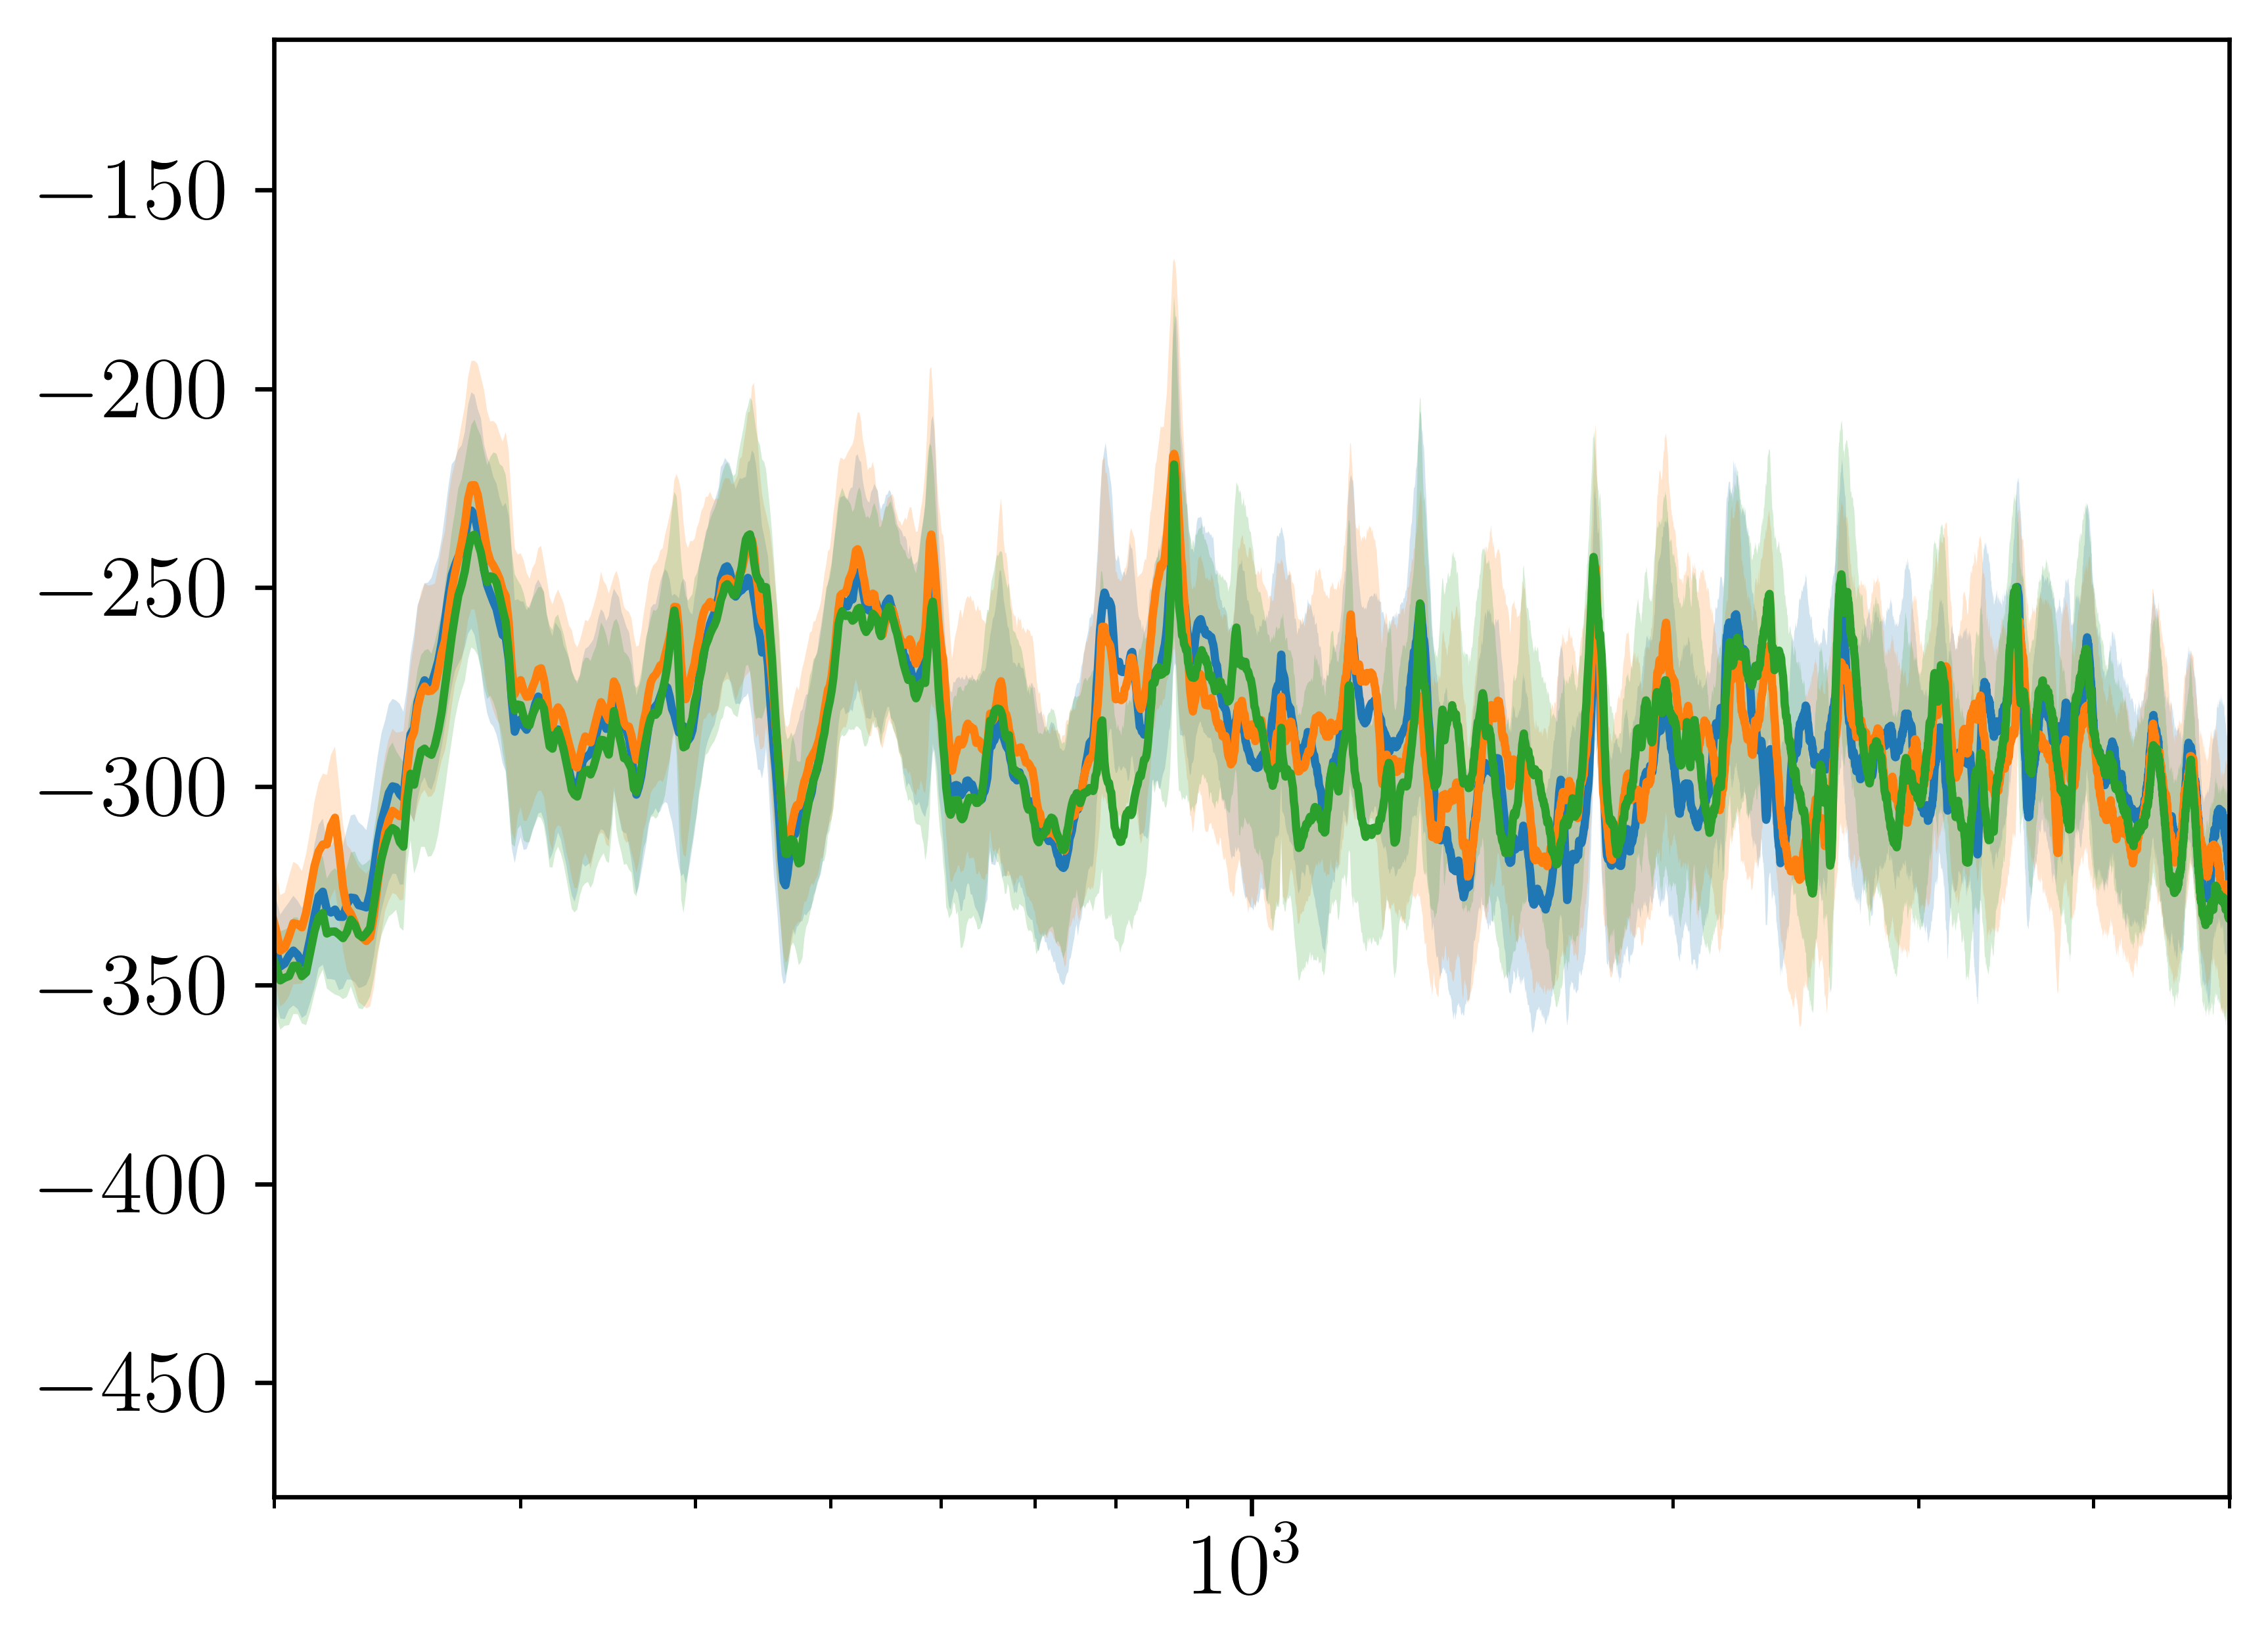

In [12]:
fig, ax = plt.subplots()
stats = ltass.groupby('violin')['H'].agg(['mean', std])
stats['f'] = ltass.groupby('violin')['f'].first()
for i, row in stats.iterrows():
    ax.plot(row['f'], row['mean'])
    ax.fill_between(
        row['f'],
        row['mean'] + row['std'],
        row['mean'] - row['std'],
        alpha=.2
    )
ax.set_xscale('log')
ax.set_xlim([200, 5000])

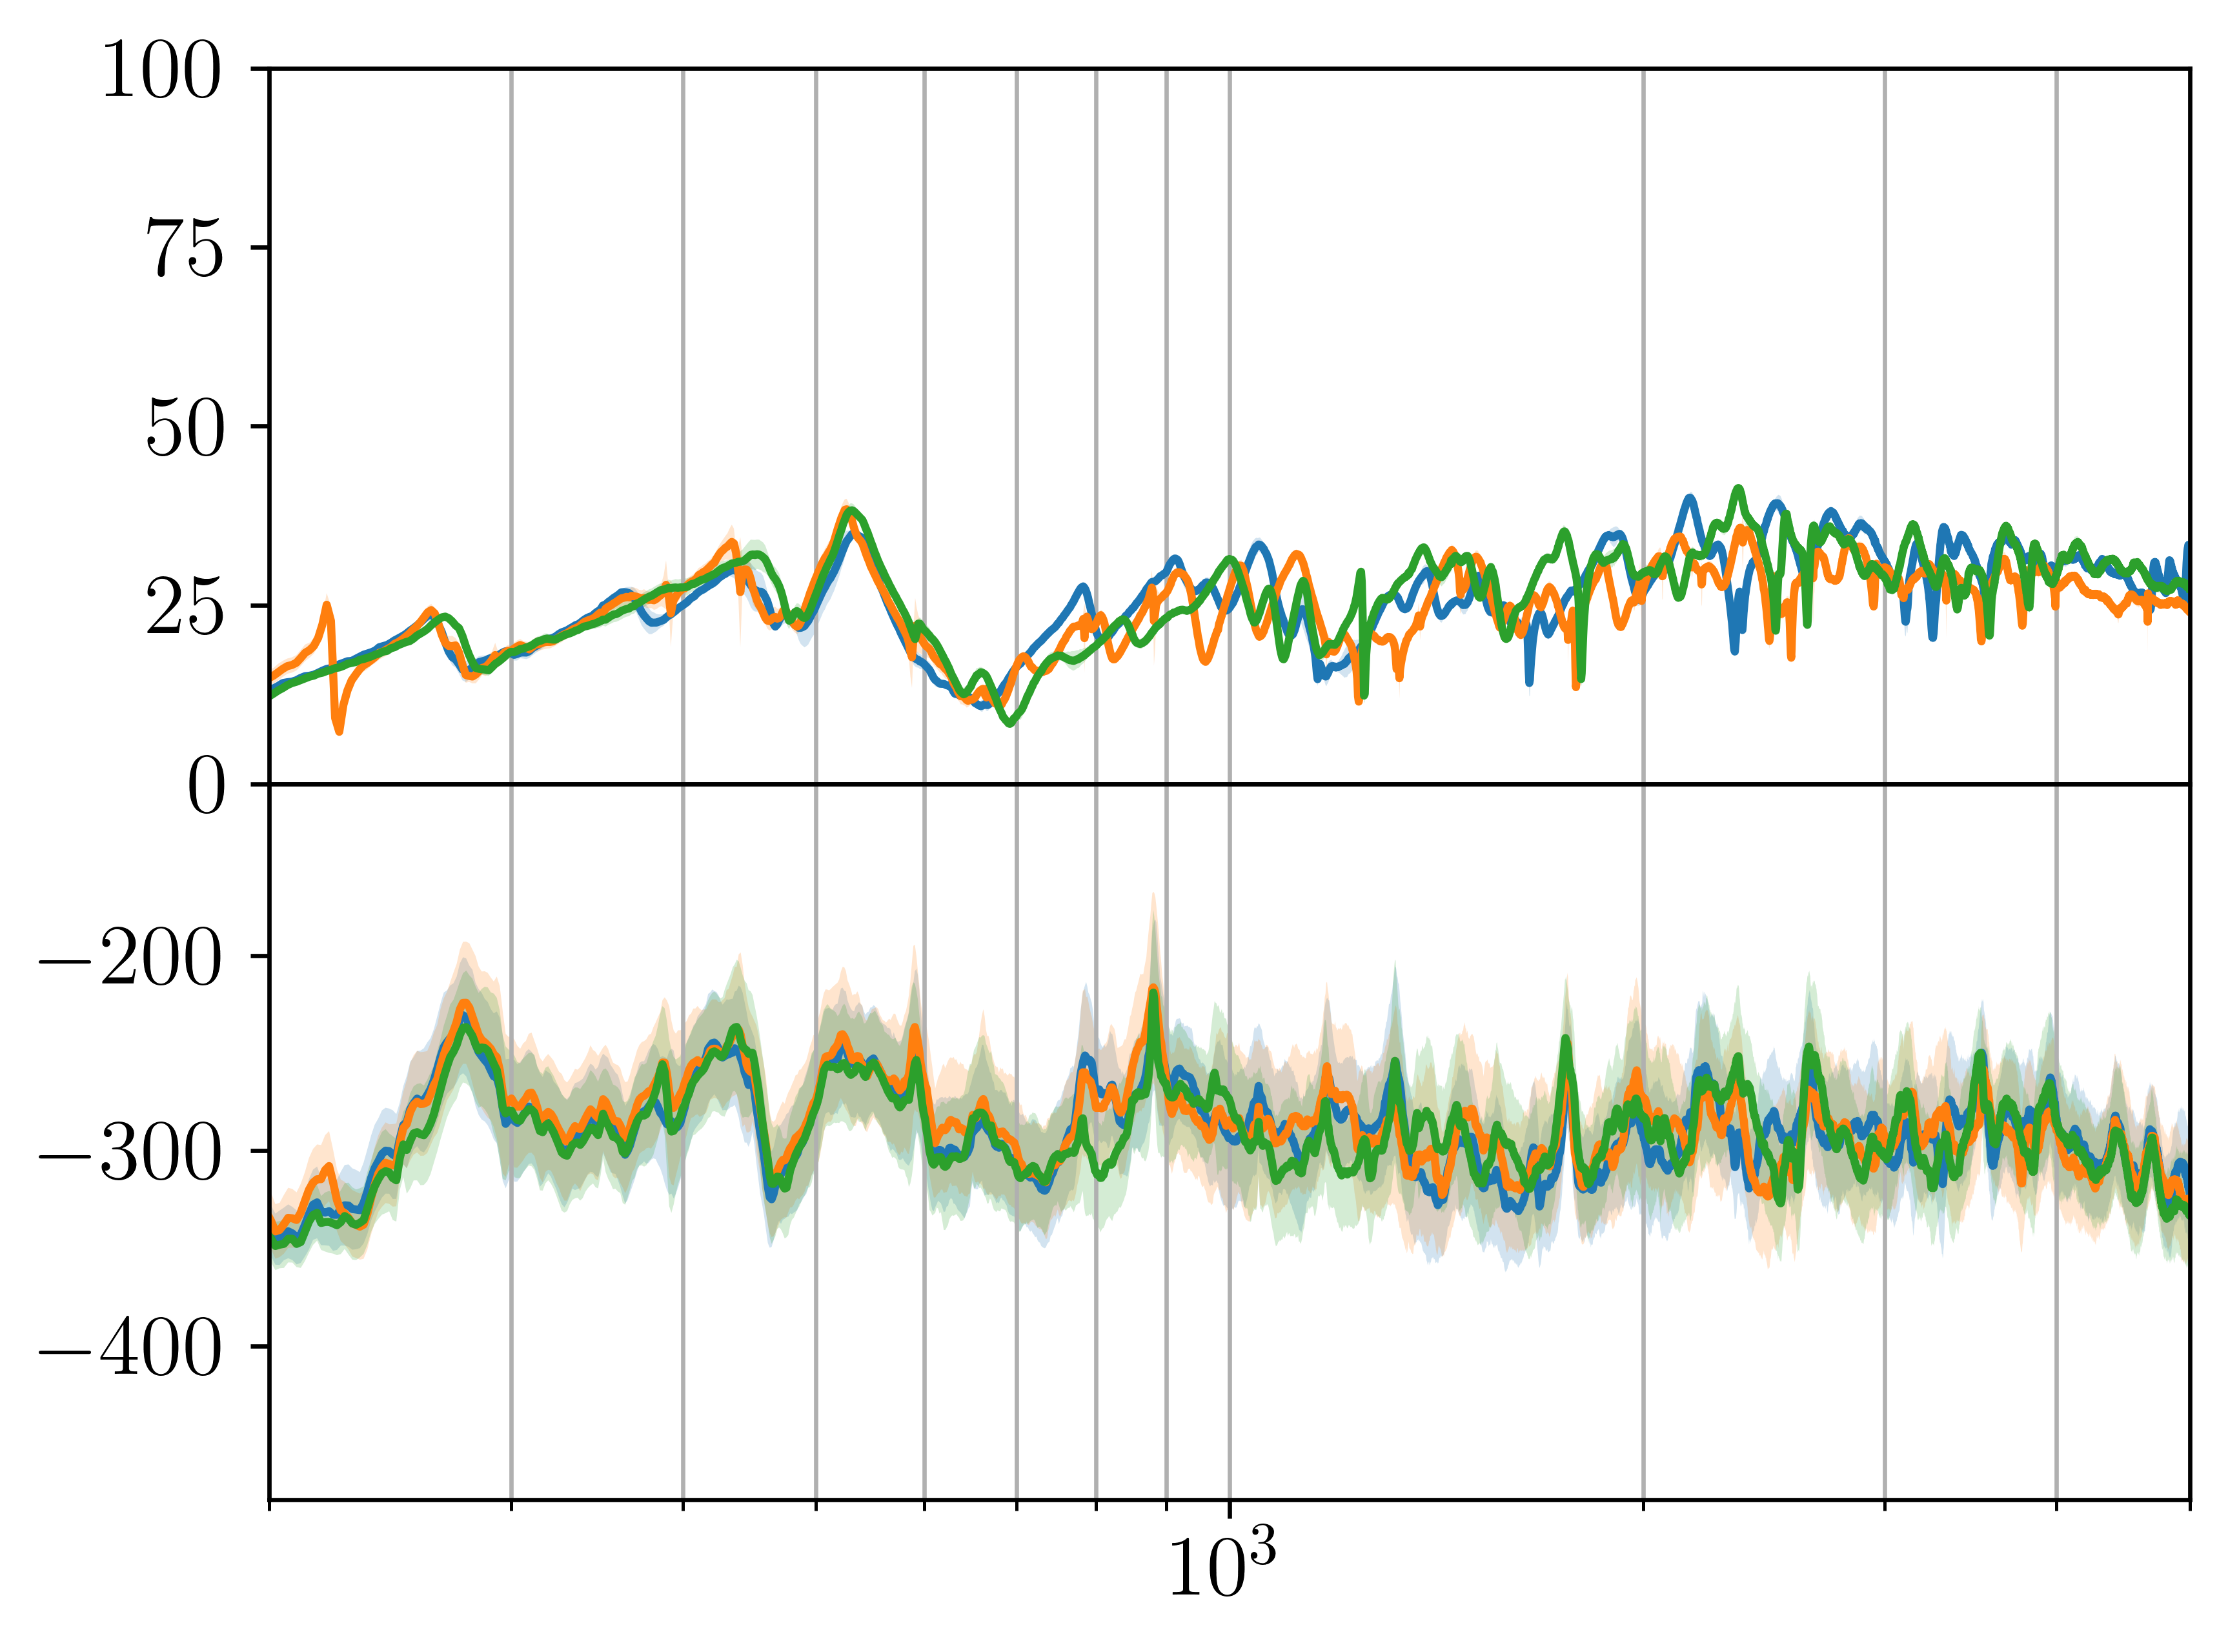

In [16]:
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=.0)

stats = frfs.groupby('violin')['H'].agg(['mean', std])
stats['f'] = frfs.groupby('violin')['f'].first()
for i, row in stats.iterrows():
    ax1.plot(row['f'], row['mean'])
    ax1.fill_between(
        row['f'],
        row['mean'] + row['std'],
        row['mean'] - row['std'],
        alpha=.2
    )

# stats = frfs.groupby('violin')['H_c'].agg(['mean', std])
# stats['f'] = frfs.groupby('violin')['f'].first()
# for i, row in stats.iterrows():
#     ax2.plot(row['f'], row['mean'])
#     ax2.fill_between(
#         row['f'],
#         row['mean'] + row['std'],
#         row['mean'] - row['std'],
#         alpha=.2
#     )

stats = ltass.groupby('violin')['H'].agg(['mean', std])
stats['f'] = ltass.groupby('violin')['f'].first()
for i, row in stats.iterrows():
    ax3.plot(row['f'], row['mean'])
    ax3.fill_between(
        row['f'],
        row['mean'] + row['std'],
        row['mean'] - row['std'],
        alpha=.2
    )

ax1.set_xscale('log')
ax1.set_xlim([200, 5000])
ax1.set_ylim([0, 100])
# ax2.set_ylim([0, 100])
ax.set_xticks(np.arange(3, 4, step=0.1))
# ax1.set_xticks([100, 200, ])
ax1.grid(axis='x', which='both')
# ax2.grid(axis='x', which='both')
ax3.grid(axis='x', which='both')
plt.savefig('../reports/figures/admittance-vs-ltas.png', dpi=600, bbox_inches='tight')

In [50]:
# admittance_S /= np.mean(admittance_S[:, admittance_f < 4000])
# recording_S /= np.mean(np.abs(recording_S[:, recording_f < 4000]))

admittance_S_db = 20 * np.log(np.abs(admittance_S) * Ss.mean(axis=0))
# admittance_S_db /= np.mean(admittance_S_db[:, admittance_f < 4000])
admittance_S_mean = np.mean(admittance_S_db, axis=0)
admittance_S_std = np.std(admittance_S_db, axis=0)

recording_S_db = 20 * np.log(np.abs(recording_S))
# recording_S_db /= np.mean(np.abs(recording_S_db)[:, recording_f < 4000])
recordings_S_mean = np.mean(recording_S_db, axis=0)+2
recordings_S_std = np.std(recording_S_db, axis=0)

fig, ax1 = plt.subplots()

ax1.plot(admittance_f, admittance_S_mean)
ax1.fill_between(
    admittance_f, 
    admittance_S_mean + admittance_S_std,
    admittance_S_mean - admittance_S_std,
    alpha=.2
)

ax2 = ax1.twinx()
ax2.plot(recording_f, recordings_S_mean, color='orange')
ax2.fill_between(
    recording_f, 
    recordings_S_mean + recordings_S_std,
    recordings_S_mean - recordings_S_std,
    color='orange',
    alpha=.2
)
ax1.set_xscale('log')
ax1.set_xlim([200, 5000])
# ax1.set_ylim([-100, 100])

NameError: name 'admittance_S' is not defined

In [191]:
correlation = np.corrcoef(admittance_S_mean[admittance_f < 5000], recordings_S_mean[ admittance_f < 5000])
print(correlation)

[[1.         0.18066414]
 [0.18066414 1.        ]]


In [3]:
def sawtooth(f0, n_fft, sr):
    S = np.zeros(n_fft // 2 + 1, dtype=complex)
    df = sr / n_fft

    max_harmonic = (sr/2) // f0
    harmonics = np.arange(1, max_harmonic + 1)
    amplitudes = -1j * (1 / harmonics)

    S[(harmonics * f0 / df).astype(int)] = amplitudes
    return np.abs(S)

/tmp/ipykernel_62382/2438236844.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.linspace(0, 48000//2, 32768//2+1), np.log10(Ss_mean))


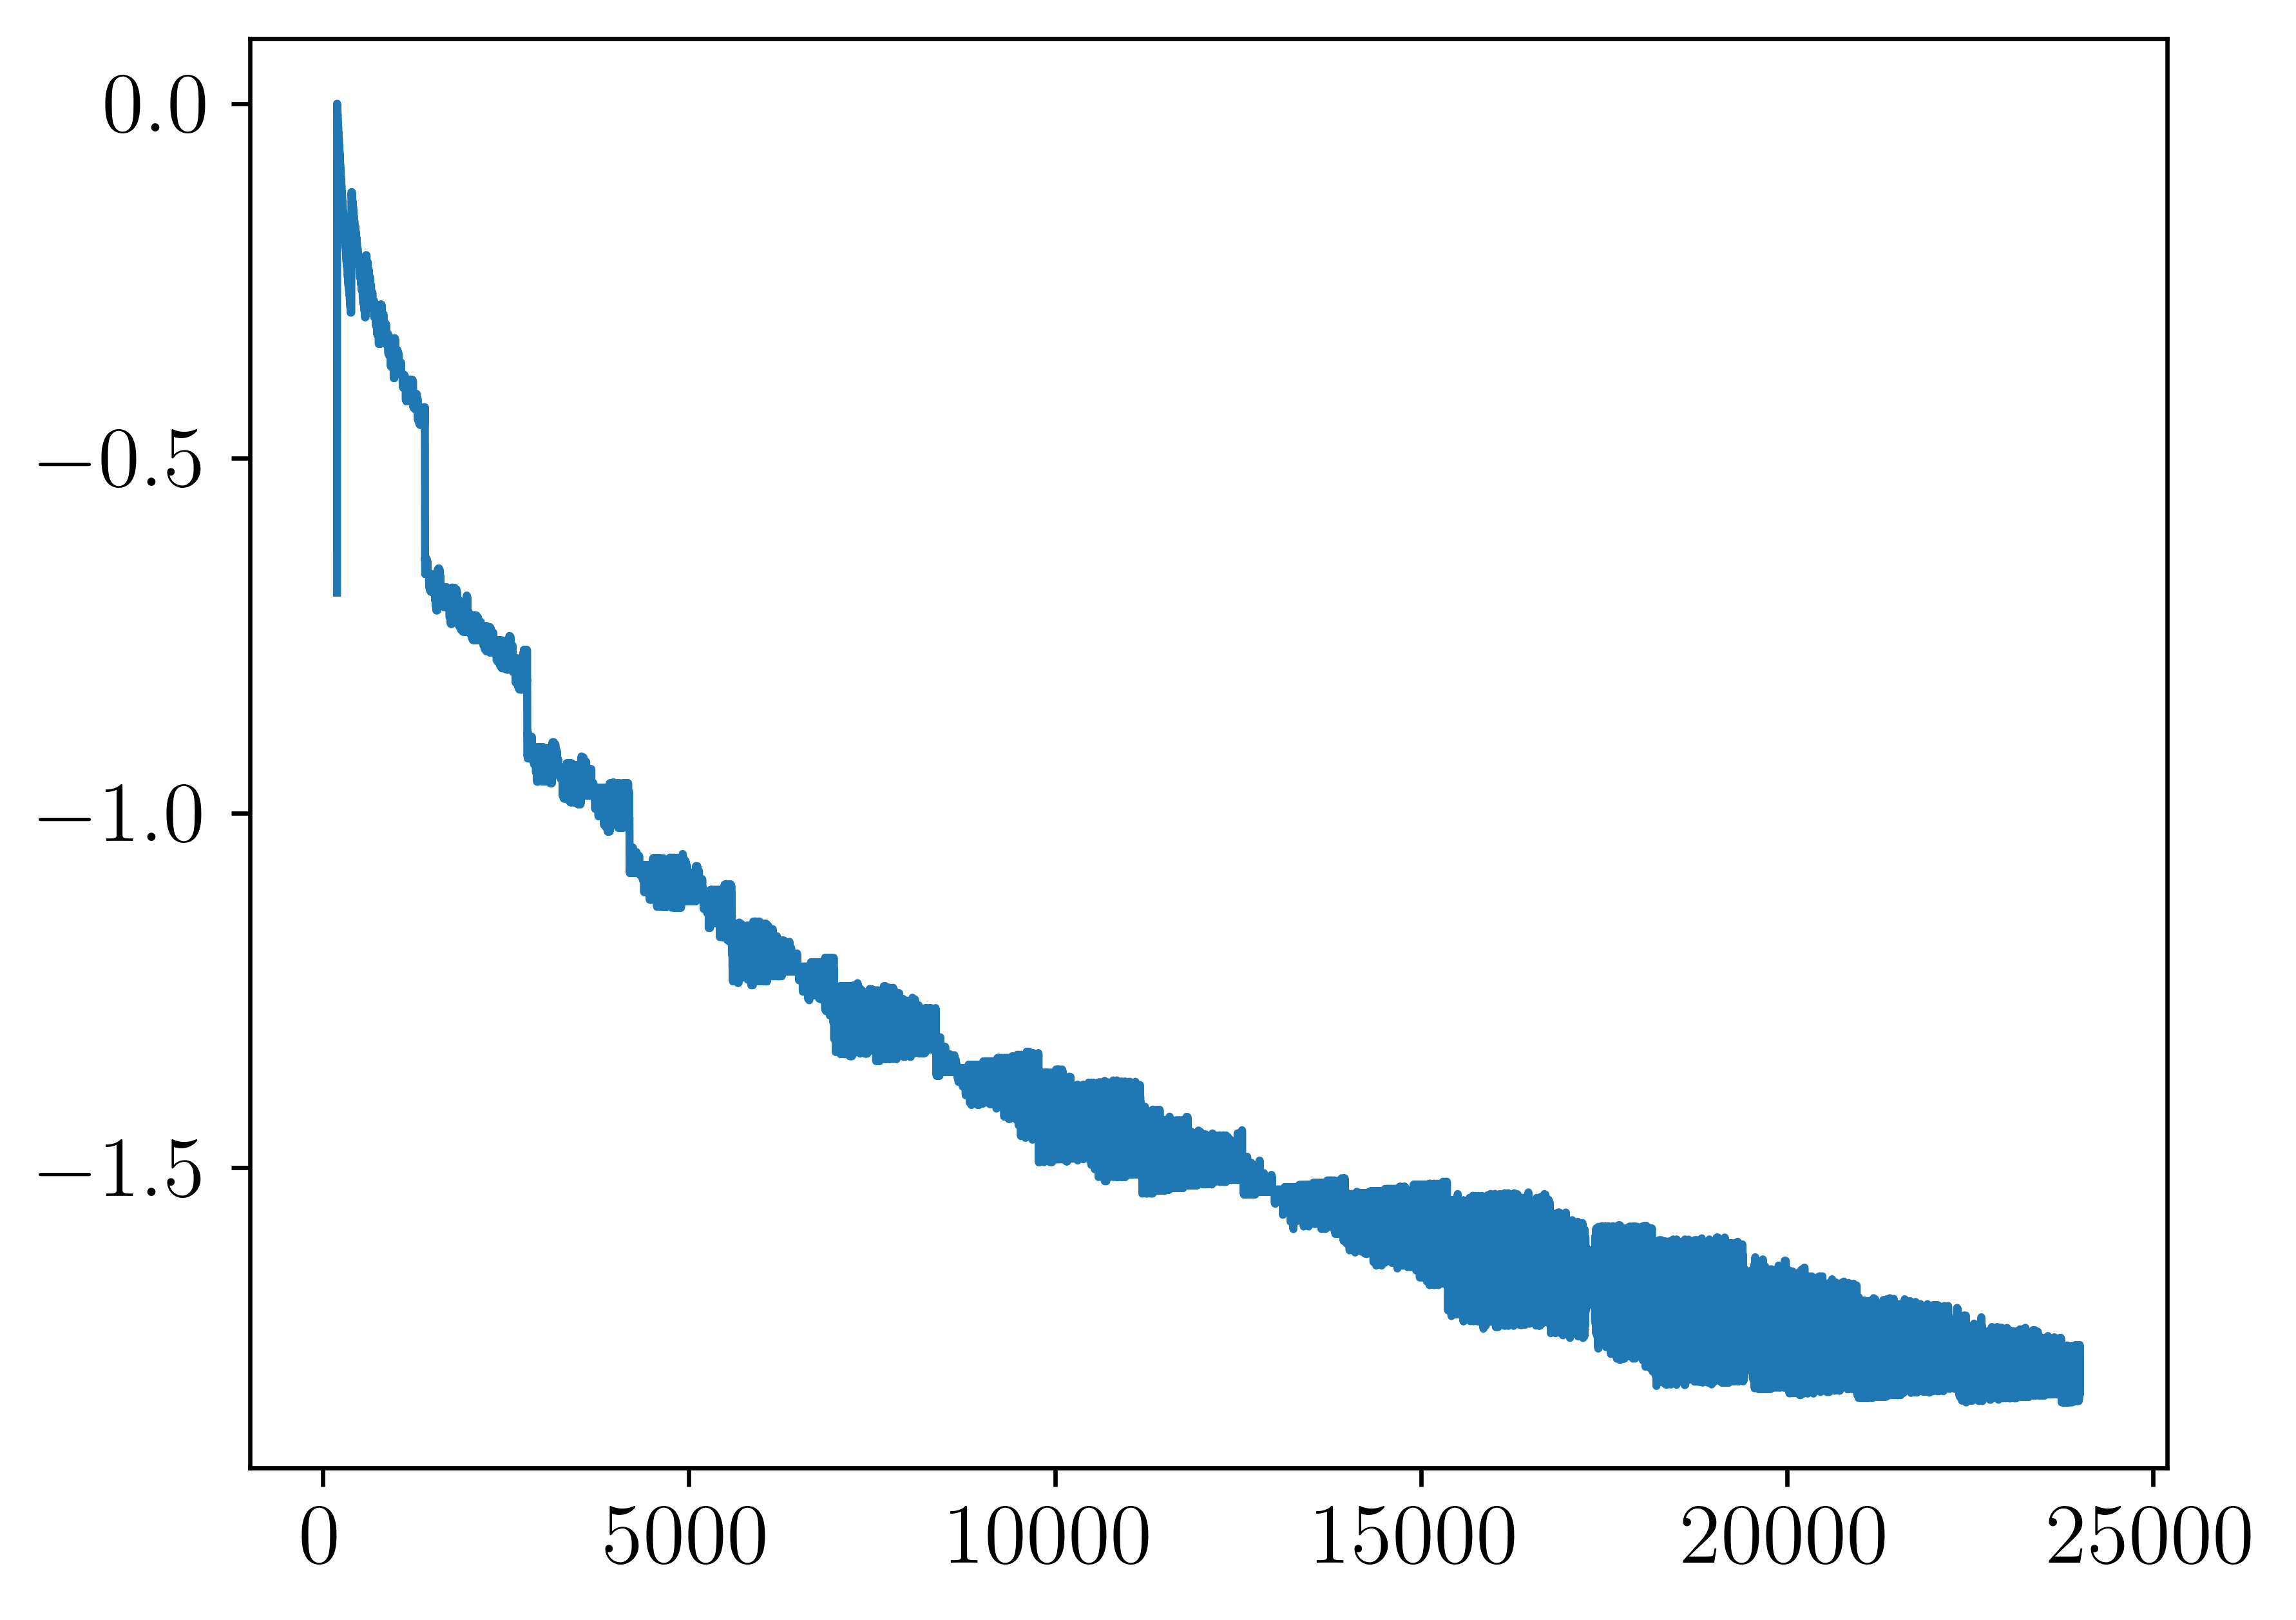

In [11]:
# subdivision = 1024
# notes = np.arange(-14*subdivision, 20*subdivision)
# freqs = 440 * np.power(2, notes/(12*subdivision))
# Ss = np.array([sawtooth(f0, 32768, 48000) for f0 in freqs])
# Ss_mean = Ss.mean(axis=0)
# Ss_mean /= Ss_mean.max()
plt.plot(np.linspace(0, 48000//2, 32768//2+1), np.log10(Ss_mean))
plt.show()